In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

In [27]:
model = tf.keras.models.load_model("./unet_models/epochs60.h5")

In [9]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [4]:
x = np.ones((2894, 128, 128))
x_val = np.load("processed_data/val/seismic.npy")
y_val = np.load("processed_data/val/annotation.npy")

In [5]:
x.shape

(2894, 128, 128)

In [38]:
i = 234
large_image_scaled = x_val[i]
large_image_scaled = np.expand_dims(large_image_scaled, axis=2)
# large_image_scaled = np.reshape(x_val[i],(x_val[i].shape[0],x_val[0].shape[1],1))
large_image_scaled.shape

(512, 512, 1)

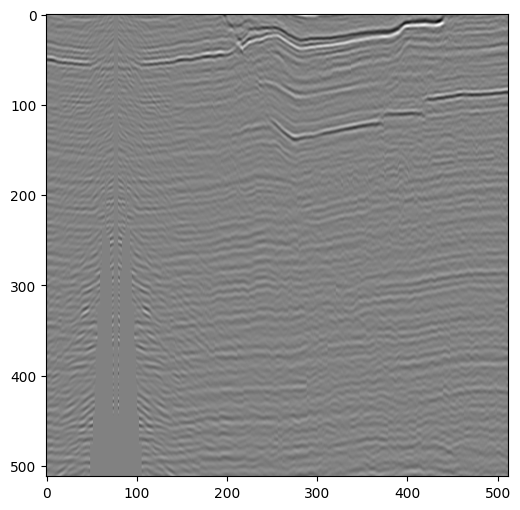

In [39]:
plt.figure(figsize = (8,6))
plt.imshow(large_image_scaled,"gray")
plt.show()

In [11]:
patch_size=128
n_classes=1

In [40]:
predictions_smooth = predict_img_with_smooth_windowing(
    large_image_scaled,    #Must be of shape (x, y, c) --> NOT of the shape (n, x, y, c)
    window_size=patch_size,
    subdivisions=4,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

  0%|                                                                | 0/8 [00:00<?, ?it/s]

12/12 [==============================] - 4s 381ms/step


 12%|███████                                                 | 1/8 [00:05<00:35,  5.04s/it]

12/12 [==============================] - 4s 327ms/step


 25%|██████████████                                          | 2/8 [00:09<00:27,  4.62s/it]

12/12 [==============================] - 4s 336ms/step


 38%|█████████████████████                                   | 3/8 [00:13<00:22,  4.53s/it]

12/12 [==============================] - 4s 332ms/step


 50%|████████████████████████████                            | 4/8 [00:18<00:17,  4.46s/it]

12/12 [==============================] - 4s 349ms/step


 62%|███████████████████████████████████                     | 5/8 [00:22<00:13,  4.52s/it]

12/12 [==============================] - 4s 338ms/step


 75%|██████████████████████████████████████████              | 6/8 [00:27<00:08,  4.49s/it]

12/12 [==============================] - 4s 331ms/step


 88%|█████████████████████████████████████████████████       | 7/8 [00:31<00:04,  4.44s/it]

12/12 [==============================] - 4s 326ms/step


100%|████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.48s/it]


In [41]:
# final_prediction = np.argmax(predictions_smooth, axis=2)
final_prediction = threshold_image(predictions_smooth,0.074)

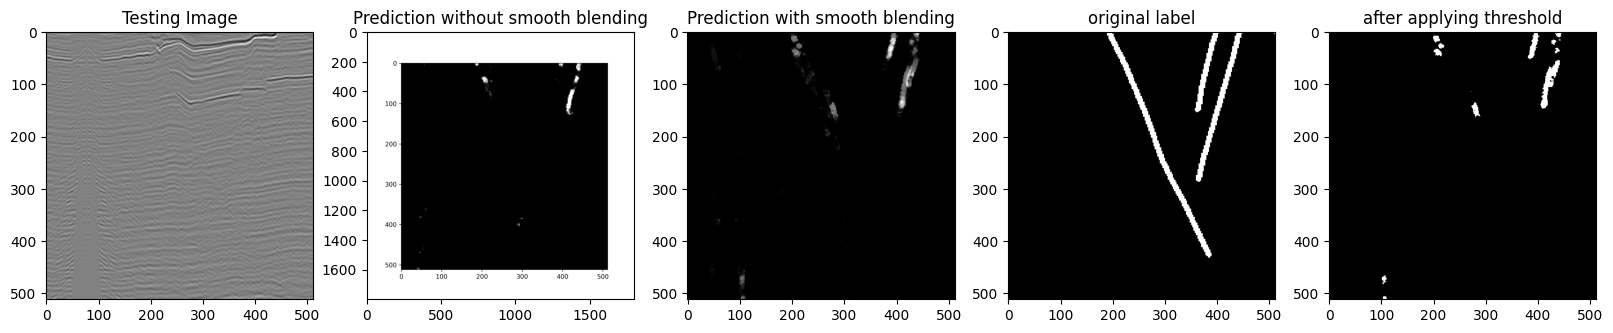

In [42]:
plt.figure(figsize=(20, 10))
plt.subplot(151)
plt.title('Testing Image')
plt.imshow(x_val[i], cmap='gray')
plt.subplot(152)
plt.title('Prediction without smooth blending')
img = plt.imread(str(i)+"epochs.png")
plt.imshow(img,"gray")
plt.subplot(153)
plt.title('Prediction with smooth blending')
plt.imshow(predictions_smooth,"gray")
plt.subplot(154)
plt.title("original label")
plt.imshow(y_val[i],"gray")
plt.subplot(155)
plt.title("after applying threshold")
plt.imshow(final_prediction,"gray")
plt.show()

In [14]:
def threshold_image(img,thres):
    """Numpy indexing"""
    img_thres = np.copy(img)
    img_thres[ img_thres < thres ] = 0
    img_thres[img_thres>thres] = 1
    return img_thres

In [139]:
# sharpeninig the edges

In [32]:
import cv2
import numpy as np

# read image as grayscale
img = cv2.imread('110_epochs_smooth.png', cv2.IMREAD_GRAYSCALE)

# threshold to binary
# img = cv2.cvtColor(final_prediction, cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# find contours - write black over all small contours
letter = morph.copy()
cntrs = cv2.findContours(morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]
for c in cntrs:
    area = cv2.contourArea(c)
    if area < 100:
        cv2.drawContours(letter,[c],0,(0,0,0),-1)

# do canny edge detection
edges = cv2.Canny(letter, 200, 200)

# write results
cv2.imwrite("K_thresh.png", thresh)
cv2.imwrite("K_morph.png", morph)
cv2.imwrite("K_letter.png", letter)
cv2.imwrite("K_edges.png", edges)

# show results
cv2.imshow("K_thresh", thresh)
cv2.imshow("K_morph", morph)
cv2.imshow("K_letter", letter)
cv2.imshow("K_edges", edges)
cv2.waitKey(0)

107

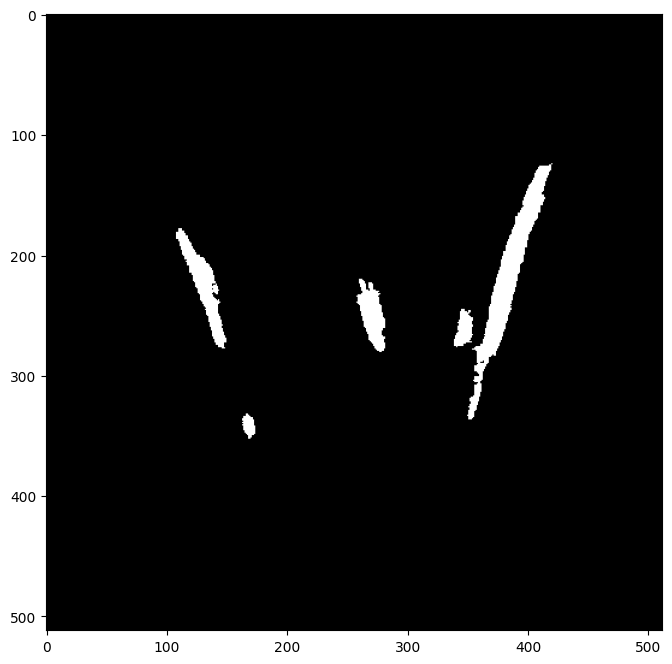

In [31]:
plt.figure(figsize = (8,8))
plt.imshow(final_prediction,"gray")
plt.savefig("110_epochs_smooth.png",dpi=200)